# 금융데이터베이스 Group 7 기말프로젝트

* 20249032	곽기은	klutzduck@kaist.ac.kr
* 20249124	김태훈	thk24@kaist.ac.kr
* 20249197	서승건	seanseo@kaist.ac.kr
* 20249366	장우석	expressj@kaist.ac.kr
* 20249402	조영민	youngmin.cho@kaist.ac.kr
* 20249459	홍성수	seongsu.hong@kaist.ac.kr

In [87]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from pandas.tseries.offsets import MonthEnd, YearEnd
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from pathlib import Path

# https://ecos.bok.or.kr/api/#/DevGuide/DevSpeciflcation
# SSL 보안 장비 등으로 인해 SSL Verification Error가 발생할 경우에 대비해서 requests.get할 때 verify = False하고, warning을 무시하도록 설정한다.
# SSL Verification을 끈다.
import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
# 한국은행 API를 사용하기 위한 인증정보를 설정한다.
BOK_API_URL = 'https://ecos.bok.or.kr/api'
BOK_API_KEY = 'W2HQL3IHAD2LKU409JDH'

## Convert to monthly observations
### End-of-month observation

In [3]:
df_xr = pd.read_excel(Path('data/krw_jpy_xr.xlsx'))
df_xr = df_xr.set_index('date')
df_monthly = df_xr.resample('ME').last()
df_monthly['ret'] = df_monthly['KRW/JPY'].pct_change() * 100
df_monthly = df_monthly.dropna()
df_monthly.head(3)

,KRW/JPY,ret
date,,
1977-05-31,174.67,0.223778
1977-06-30,180.11,3.114444
1977-07-31,181.95,1.021598


## 환율 변화율을 예측하기

### IMF 이전 환율정책:

* IMF 외환위기 이전 한국은 '관리변동환율제'를 채택하고 있었습니다.
* 이 제도 하에서 정부는 환율의 일일 변동폭을 제한하고, 외환시장에 직접 개입하여 환율을 관리했습니다.


### IMF 이후 환율정책:

* 1997년 12월 IMF 구제금융을 받으면서 한국은 '자유변동환율제'로 전환했습니다.
* 이 제도에서는 원칙적으로 시장의 수요와 공급에 따라 환율이 결정됩니다.
* 정부의 직접적인 시장 개입은 크게 줄어들었습니다

### 아베노믹스 (2012년~): 2012년 12월 26일

* 영향력: 매우 큼
* 지속기간: 장기적 (수년간 지속)
* 직접성: 엔화 환율에 직접적인 영향
* 의도성: 의도적인 엔화 약세 정책

### 아베노믹스는 일본 경제 회복을 위해 의도적으로 엔화 가치를 낮추는 정책을 포함했습니다. 
### 이로 인해 엔화 가치가 급격히 하락했고, 원/엔 환율에 지속적이고 큰 영향을 미쳤습니다.

In [4]:
df_monthly = df_monthly.loc['2012-12-26':]

X = df_monthly.iloc[:-1]['ret']
X = sm.add_constant(X)
Y = df_monthly.iloc[1:]['ret']

sm.OLS(Y, X.values).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                   0.02576
Date:                Sun, 11 Aug 2024   Prob (F-statistic):              0.873
Time:                        11:32:53   Log-Likelihood:                -323.52
No. Observations:                 140   AIC:                             651.0
Df Residuals:                     138   BIC:                             656.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1733      0.209     -0.830      0.408      -0.586       0.239
x1             0.0135      0.084      0.160      0.873      -0.153       0.180
==============================================================================
Omnibus:                        0.600   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.741   Jarque-Bera (JB):                0.595
Skew:                           0.154   Prob(JB):                        0.743
Kurtosis:                       2.913   Cond. No.                         2.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

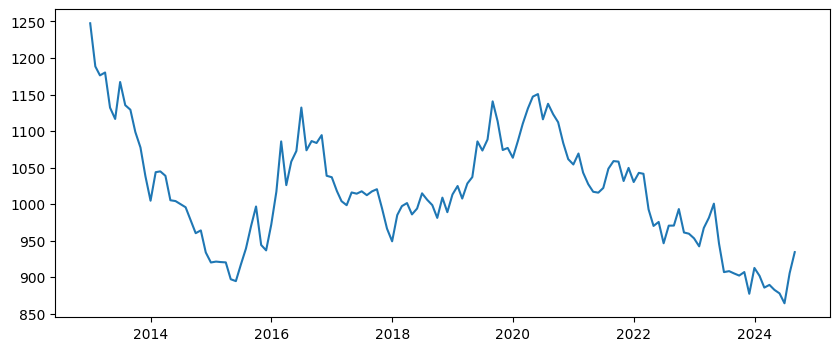

In [5]:
plt.rcParams['figure.figsize'] = (10, 4)
plt.plot(df_monthly['KRW/JPY'])
plt.show()

In [6]:
df_real_xr = pd.read_excel(Path('data/world_real_xr.xls'), sheet_name = 'Data', skiprows = 3)
df_real_xr = df_real_xr.set_index('Country Code')

In [7]:
df_real_xr_kor = df_real_xr.loc['KOR'].to_frame()
df_real_xr_kor = df_real_xr_kor.iloc[3:]
df_real_xr_kor = df_real_xr_kor.dropna()
df_real_xr_kor['KOR'] = df_real_xr_kor['KOR'].astype(float)
df_real_xr_kor['date'] = pd.to_datetime(df_real_xr_kor.index) + YearEnd()
df_real_xr_kor = df_real_xr_kor.set_index('date')
df_real_xr_kor.columns = ['KOR Real XR']
df_real_xr_kor.head(3)

,KOR Real XR
date,
1990-12-31,0.791111
1991-12-31,0.806041
1992-12-31,0.797916


In [8]:
df_real_xr_jpn = df_real_xr.loc['JPN'].to_frame()
df_real_xr_jpn = df_real_xr_jpn.iloc[3:]
df_real_xr_jpn = df_real_xr_jpn.dropna()
df_real_xr_jpn['JPN'] = df_real_xr_jpn['JPN'].astype(float)
df_real_xr_jpn['date'] = pd.to_datetime(df_real_xr_jpn.index) + YearEnd()
df_real_xr_jpn = df_real_xr_jpn.set_index('date')
df_real_xr_jpn.columns = ['JPN Real XR']
df_real_xr_jpn.head(3)

,JPN Real XR
date,
1990-12-31,1.295738
1991-12-31,1.386324
1992-12-31,1.465824


In [9]:
# 기존의 KOR와 JPN 데이터프레임을 합칩니다
df_combined = pd.concat([df_real_xr_kor, df_real_xr_jpn], axis = 1)

# KRW/JPY 실질환율 계산
# KRW/USD를 JPY/USD로 나눈다.
df_combined['KRW/JPY Real XR'] = df_combined['KOR Real XR'] / (df_combined['JPN Real XR'])

# 결과 확인
df_combined.tail(3)

,KOR Real XR,JPN Real XR,KRW/JPY Real XR
date,,,
2021-12-31,0.723172,0.899195,0.804244
2022-12-31,0.627537,0.721953,0.869221
2023-12-31,0.612982,0.673903,0.909600


In [10]:
df_real_xr = df_combined['KRW/JPY Real XR']

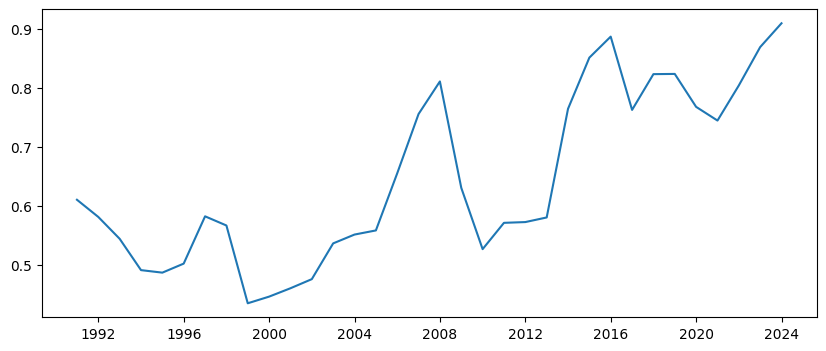

In [11]:
plt.plot(df_real_xr)
plt.show()

## Overlapping monthly forecasts

In [12]:
df_monthly = df_monthly.drop('ret', axis = 1)
df_merged = df_monthly.join(df_real_xr)
# ffill - forward fill
# bfill - backward fill
df_merged['KRW/JPY Real XR'] = df_merged['KRW/JPY Real XR'].ffill()

df_merged['ann_ret'] = df_merged['KRW/JPY'].pct_change(periods = 12) * 100

df_merged['F12.ann_ret'] = df_merged['ann_ret'].shift(-12)

df_merged.head(15)


,KRW/JPY,KRW/JPY Real XR,ann_ret,F12.ann_ret
date,,,,
2012-12-31,1247.50,0.580543,NaN,-19.466132
2013-01-31,1188.47,0.580543,NaN,-12.180366
2013-02-28,1176.20,0.580543,NaN,-11.169869
2013-03-31,1180.13,0.580543,NaN,-11.981731
2013-04-30,1132.04,0.580543,NaN,-11.194834
2013-05-31,1116.58,0.580543,NaN,-10.066453
2013-06-30,1167.15,0.580543,NaN,-14.321210
2013-07-31,1135.40,0.580543,NaN,-12.302272
2013-08-31,1129.19,0.580543,NaN,-13.426438


### Use OLS to fit the forecast model

In [13]:
df = df_merged[['KRW/JPY Real XR', 'F12.ann_ret']]
df = df.dropna()

In [14]:
X = df['KRW/JPY Real XR']
X = sm.add_constant(X)
Y = df['F12.ann_ret']

sm.OLS(Y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            F12.ann_ret   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     42.52
Date:                Sun, 11 Aug 2024   Prob (F-statistic):           1.50e-09
Time:                        11:32:53   Log-Likelihood:                -436.42
No. Observations:                 129   AIC:                             876.8
Df Residuals:                     127   BIC:                             882.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -42.7031      6.292     -6.787      0.000     -55.153     -30.253
KRW/JPY Real XR    51.8489      7.952      6.520      0.000      36.114      67.584
==============================================================================
Omnibus:                        5.103   Durbin-Watson:                   0.236
Prob(Omnibus):                  0.078   Jarque-Bera (JB):                4.894
Skew:                           0.477   Prob(JB):                       0.0866
Kurtosis:                       3.044   Cond. No.                         20.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Real XR 대신 PPP XR 활용하기

In [15]:
def load_world_bank_data(filepath, country, column):
    df = pd.read_excel(filepath, sheet_name = 'Data', skiprows = 3)

    df = df.set_index('Country Code')
    df = df.loc[country].to_frame()
    df = df.iloc[3:]
    df = df.dropna()
    df = df.astype(float)
    
    df['date'] = pd.to_datetime(df.index) + YearEnd()
    df = df.set_index('date')
    df.columns = [column]
    
    return df

In [16]:
df_ppp_xr_kor = load_world_bank_data(Path('data/world_ppp_xr.xls'), 'KOR', 'PPP XR')
df_ppp_xr_jpn = load_world_bank_data(Path('data/world_ppp_xr.xls'), 'JPN', 'PPP XR')

In [17]:
df_ppp_combined = pd.concat([df_ppp_xr_kor, df_ppp_xr_jpn], axis = 1)
df_ppp_combined.columns = ['KOR PPP XR', 'JPN PPP XR']
df_ppp_combined['KRW/JPY PPP XR'] = df_ppp_combined['KOR PPP XR'] / (df_ppp_combined['JPN PPP XR'])
df_ppp_xr = df_ppp_combined.drop(['KOR PPP XR', 'JPN PPP XR'], axis = 1)

In [18]:
df_ppp_xr.head(3)

,KRW/JPY PPP XR
date,
1990-12-31,2.984441
1991-12-31,3.165311
1992-12-31,3.355232


### Merge with monthly observations

In [19]:
df_merged = df_monthly.join(df_real_xr)
df_merged = df_merged.join(df_ppp_xr)
df_merged.head(3)

,KRW/JPY,KRW/JPY Real XR,KRW/JPY PPP XR
date,,,
2012-12-31,1247.50,0.580543,8.198472
2013-01-31,1188.47,NaN,NaN
2013-02-28,1176.20,NaN,NaN


### Compute Real XR

In [20]:
df_merged['KRW/JPY PPP XR'] = df_merged['KRW/JPY PPP XR'].ffill()
df_merged.head(3)

,KRW/JPY,KRW/JPY Real XR,KRW/JPY PPP XR
date,,,
2012-12-31,1247.50,0.580543,8.198472
2013-01-31,1188.47,NaN,8.198472
2013-02-28,1176.20,NaN,8.198472


In [21]:
df_merged['New Real XR'] = df_merged['KRW/JPY PPP XR'] / df_merged['KRW/JPY'] * 100
df_merged.tail(3)

,KRW/JPY,KRW/JPY Real XR,KRW/JPY PPP XR,New Real XR
date,,,,
2024-06-30,864.31,NaN,8.453422,0.978054
2024-07-31,905.44,NaN,8.453422,0.933626
2024-08-31,934.32,NaN,8.453422,0.904767


In [22]:
df_merged['KRW/JPY Real XR'] = df_merged['KRW/JPY Real XR'].ffill()

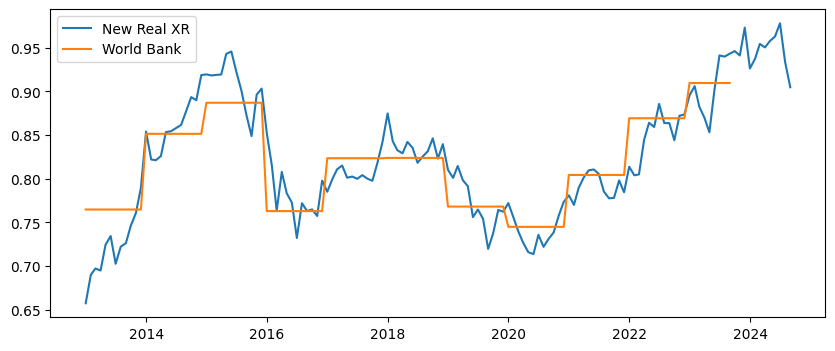

In [23]:
plt.plot(df_merged['New Real XR'], label='New Real XR')
plt.plot(df_merged['KRW/JPY Real XR'].shift(-12), label='World Bank')
plt.legend()
plt.show()

## Compute annual XR return

In [24]:
df_merged['ann_ret'] = df_merged['KRW/JPY'].pct_change(periods = 12) * 100
df_merged['F12.ann_ret'] = df_merged['ann_ret'].shift(-12)
df_merged.head(5)

,KRW/JPY,KRW/JPY Real XR,KRW/JPY PPP XR,New Real XR,ann_ret,F12.ann_ret
date,,,,,,
2012-12-31,1247.50,0.580543,8.198472,0.657192,NaN,-19.466132
2013-01-31,1188.47,0.580543,8.198472,0.689834,NaN,-12.180366
2013-02-28,1176.20,0.580543,8.198472,0.697030,NaN,-11.169869
2013-03-31,1180.13,0.580543,8.198472,0.694709,NaN,-11.981731
2013-04-30,1132.04,0.580543,8.198472,0.724221,NaN,-11.194834


### Use OLS to fit the forecast model

In [25]:
df = df_merged[['New Real XR', 'F12.ann_ret']]
df = df.dropna()

X = df['New Real XR']
X = sm.add_constant(X)
Y = df['F12.ann_ret']

results = sm.OLS(Y,X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            F12.ann_ret   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     52.98
Date:                Sun, 11 Aug 2024   Prob (F-statistic):           3.10e-11
Time:                        11:32:53   Log-Likelihood:                -432.56
No. Observations:                 129   AIC:                             869.1
Df Residuals:                     127   BIC:                             874.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -59.1016      7.884     -7.496      0.000     -74.703     -43.500
New Real XR    70.3263      9.661      7.279      0.000      51.208      89.445
==============================================================================
Omnibus:                        4.320   Durbin-Watson:                   0.146
Prob(Omnibus):                  0.115   Jarque-Bera (JB):                3.365
Skew:                           0.273   Prob(JB):                        0.186
Kurtosis:                       2.428   Cond. No.                         26.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Predict XR

In [26]:
last_obs = df_merged.iloc[-1]
last_obs

KRW/JPY            934.320000
KRW/JPY Real XR      0.909600
KRW/JPY PPP XR       8.453422
New Real XR          0.904767
ann_ret              3.231794
F12.ann_ret               NaN
Name: 2024-08-31 00:00:00, dtype: float64

In [27]:
last_xr = last_obs['KRW/JPY']
last_real_xr = last_obs['New Real XR']

In [28]:
last_xr

np.float64(934.32)

In [29]:
last_real_xr

np.float64(0.9047673662483775)

### OLS 결과 그대로 사용하여 예측

In [30]:
#exogeneous variables
exog = [1, last_real_xr]
results.predict(exog = exog)

array([4.52728093])

### Confidence Interval

In [31]:
for alpha in [0.05, 0.25, 0.50]:
    prstd, iv_l, iv_u = wls_prediction_std(results, exog = exog, alpha = alpha)
    
    print('Confidence interval at alpha = {:.2f}: {:.2f} ~ {:.2f}'.format(
        alpha,
        iv_l[0],
        iv_u[0],
    ))

Confidence interval at alpha = 0.05: -9.43 ~ 18.49
Confidence interval at alpha = 0.25: -3.63 ~ 12.68
Confidence interval at alpha = 0.50: -0.25 ~ 9.30


### 환율 예측하기

In [32]:
pred_ret = results.predict(exog = exog)
last_xr * (1 + pred_ret[0] / 100)

np.float64(976.6192911547107)

In [33]:
for alpha in [0.05, 0.25, 0.50]:
    prstd, iv_l, iv_u = wls_prediction_std(results, exog = exog, alpha = alpha)
    
    print('Confidence interval at alpha = {:.2f}: {:.2f} ~ {:.2f}'.format(
        alpha,
        last_xr * (1 + iv_l[0] / 100),
        last_xr * (1 + iv_u[0] / 100),
    ))

Confidence interval at alpha = 0.05: 846.18 ~ 1107.06
Confidence interval at alpha = 0.25: 900.44 ~ 1052.80
Confidence interval at alpha = 0.50: 932.03 ~ 1021.21


## 추가 지표 획득

In [77]:
def fetch_bok_data(service_code, stat_code=None, item=None):
    url = f"{BOK_API_URL}/{service_code}/{BOK_API_KEY}/json/kr/1/100000"
    
    if item is not None:
        url += "/{}/{}/{}/{}/{}".format(item['STAT_CODE'], item['CYCLE'], item['START_TIME'], item['END_TIME'], item['ITEM_CODE'])
        
        if type(item['ITEM_CODE2']) is str:
            url += f"/{item['ITEM_CODE2']}"
        
    elif stat_code is not None:
        url += f"/{stat_code}"
    
    print(url)
    
    resp = requests.get(url, verify = False)
    results = resp.json()
    rows = results[service_code]['row']
    df = pd.DataFrame(rows)
    
    return df

In [35]:
TARGET_STAT_CODES = [
    '731Y001',  # 3.1.1.1. 주요국 통화의 대원화환율
    '902Y008',  # 9.1.2.2. 국제 주요국 소비자물가지수
    '902Y009',  # 9.1.3.1. 국제 주요국 경상수지
    '902Y015',  # 9.1.4.1. 국제 주요국 경제성장률
    '902Y016',  # 9.1.4.2. 국제 주요국 국내총생산(GDP)
    '902Y023',  # 9.1.6.1. 주요국제금리
    '817Y002',  # 1.3.2.1. 시장금리(일별)
    '732Y001',  # 3.5. 외환보유액
]

In [36]:
dfs = []

for stat_code in TARGET_STAT_CODES:
    df = fetch_bok_data('StatisticItemList', stat_code = stat_code)
    
    dfs.append(df)

https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/731Y001
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y008
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y009
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y015
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y016
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y023
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/817Y002
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/732Y001


In [37]:
df_item_codes = pd.concat(dfs, axis = 0)

In [38]:
df_item_codes.to_excel(Path('data/bok_item_codes.xlsx'), index = False)

In [39]:
df_item_codes = df_item_codes.set_index(['STAT_CODE', 'ITEM_CODE', 'CYCLE'])

### Download data values

In [40]:
data_download_list = pd.read_excel(Path('data/bok_data_download_list_jpy.xlsx'))

In [41]:
data_download_list

,name,STAT_CODE,STAT_NAME,ITEM_CODE,ITEM_CODE2,ITEM_NAME,CYCLE,UNIT_NAME
0,krw_100jpy_xr,731Y001,3.1.1.1. 주요국 통화의 대원화환율,0000002,NaN,원/일본엔(100엔),D,원
1,cpi_korea,902Y008,9.1.2.2. 국제 주요국 소비자물가지수,KR,NaN,한국,M,2010=100
2,cpi_jp,902Y008,9.1.2.2. 국제 주요국 소비자물가지수,JP,NaN,일본,M,2010=100
3,cpi_us,902Y008,9.1.2.2. 국제 주요국 소비자물가지수,US,NaN,미국,M,2010=100
4,current_account_korea,902Y009,9.1.3.1. 국제 주요국 경상수지,KR,NaN,한국,Q,백만달러
5,current_account_jp,902Y009,9.1.3.1. 국제 주요국 경상수지,JP,NaN,일본,Q,백만달러
6,current_account_us,902Y009,9.1.3.1. 국제 주요국 경상수지,US,NaN,미국,Q,백만달러
7,gdp_growth_korea,902Y015,9.1.4.1. 국제 주요국 경제성장률,KOR,NaN,한국,Q,%
8,gdp_growth_jp,902Y015,9.1.4.1. 국제 주요국 경제성장률,JPN,NaN,일본,Q,%
9,gdp_growth_us,902Y015,9.1.4.1. 국제 주요국 경제성장률,USA,NaN,미국,Q,%


In [42]:
#iterate over row
for idx, row in data_download_list.iterrows():
    name = row['name']
    print(f"Downloading {name}...")
    
    idx = (row.STAT_CODE, row.ITEM_CODE, row.CYCLE)
    item = df_item_codes.loc[idx]
    item ={**item, **row}
    
    df = fetch_bok_data('StatisticSearch', item = item)
    df = df[['TIME', 'DATA_VALUE']]
    
    if row['CYCLE'] == 'D':
        df['date'] = pd.to_datetime(df['TIME'])
    
    elif row['CYCLE'] == 'M':
        df['date'] = pd.to_datetime(df['TIME'], format = '%Y%m') + MonthEnd()
    
    elif row['CYCLE'] == 'Q':
        df['year'] = df['TIME'].str[:4]
        df['month'] = df['TIME'].str[-1].astype(int) * 3
        df['day'] = 1
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']]) + MonthEnd()
    
    elif row['CYCLE'] == 'A':
        df['date'] = pd.to_datetime(df['TIME']) + YearEnd()
    
    else:
        raise RuntimeError()
        
    df = df[['date','DATA_VALUE']]
    df = df.rename(columns={'DATA_VALUE': name, })
    
    df[name] = df[name].astype(float)
    
    df.to_excel(Path(f"data/{name}.xlsx"), index = False)
    
print('** Completed!! **')

https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/731Y001/D/19770401/20240809/0000002
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y008/M/195108/202406/KR
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y008/M/195501/202406/JP
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y008/M/195501/202406/US
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y009/Q/1976Q1/2024Q1/KR
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y009/Q/1996Q1/2024Q1/JP
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y009/Q/1973Q1/2024Q1/US
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y015/Q/1960Q2/2024Q2/KOR
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y015/Q/1960Q2/2024Q1/JPN
https://ecos.bok.

## BOK 파일 불러오기

In [43]:
filenames = [
    'krw_jpy_xr',
    'current_account_korea',
    'current_account_us',
    'current_account_jp',
    'gdp_korea',
    'gdp_us',
    'gdp_jp',
    'gdp_growth_korea',
    'gdp_growth_jp',
    'gdp_growth_us',
    'cpi_korea',
    'cpi_jp',
    'cpi_us',
    'int_rate_korea',
    'int_rate_jp',
    'int_rate_us',
    'foreign_reserves',
]

In [44]:
dfs = []

for fname in filenames:
    print(f"Loding {fname}....")
    
    df = pd.read_excel(Path(f"data/{fname}.xlsx"))
    df = df.set_index('date')
    
    if fname in ['gdp_growth_korea',
        'gdp_growth_jp',
        'gdp_growth_us',
        'current_account_us',
        'current_account_jp',
        'current_account_korea',
                ]:
        df[fname] = df[fname].rolling(4).sum()
    
    dfs.append(df)
    
print('** Completed **')

Loding krw_jpy_xr....
Loding current_account_korea....
Loding current_account_us....
Loding current_account_jp....
Loding gdp_korea....
Loding gdp_us....
Loding gdp_jp....
Loding gdp_growth_korea....
Loding gdp_growth_jp....
Loding gdp_growth_us....
Loding cpi_korea....
Loding cpi_jp....
Loding cpi_us....
Loding int_rate_korea....
Loding int_rate_jp....
Loding int_rate_us....
Loding foreign_reserves....
** Completed **


### World Bank 데이터로 계산했었던 KOR/JPY PPP XR 불러오기

In [45]:
dfs.append(df_ppp_xr)

## Merge the datasets

In [46]:
df_merged = pd.concat(dfs, axis = 1)
df_merged = df_merged.resample('ME').last()
df_merged = df_merged.ffill()
df_merged.loc['2010-01-01':].head()

,KRW/JPY,current_account_korea,current_account_us,current_account_jp,gdp_korea,gdp_us,gdp_jp,gdp_growth_korea,gdp_growth_jp,gdp_growth_us,cpi_korea,cpi_jp,cpi_us,int_rate_korea,int_rate_jp,int_rate_us,foreign_reserves,KRW/JPY PPP XR
date,,,,,,,,,,,,,,,,,,
2010-01-31,1287.00,33087.6,-379736.0,145677.71,943708.5,14478067.0,5289493.7,5.399,-1.661,0.118,98.82,100.09,99.37,2.88,0.20,0.45,273693584.0,7.189963
2010-02-28,1299.31,33087.6,-379736.0,145677.71,943708.5,14478067.0,5289493.7,5.399,-1.661,0.118,99.02,100.09,99.40,2.88,0.19,0.44,270659721.0,7.189963
2010-03-31,1217.68,20931.1,-382885.0,181383.81,943708.5,14478067.0,5289493.7,7.478,4.205,1.738,99.22,100.30,99.81,2.83,0.23,0.43,272331061.0,7.189963
2010-04-30,1186.77,20931.1,-382885.0,181383.81,943708.5,14478067.0,5289493.7,7.478,4.205,1.738,99.62,100.30,99.98,2.51,0.30,0.40,278873477.0,7.189963
2010-05-31,1318.54,20931.1,-382885.0,181383.81,943708.5,14478067.0,5289493.7,7.478,4.205,1.738,99.72,100.30,100.06,2.45,0.45,0.39,270221038.0,7.189963


# >>반영할 수 있는 지표들

### 환율 수익률

In [47]:
df_merged['ann_ret'] = df_merged['KRW/JPY'].pct_change(periods = 12) * 100
df_merged['F12.ann_ret'] = df_merged['ann_ret'].shift(-12)

### Real XR

In [48]:
df_merged['real_xr'] = df_merged['KRW/JPY PPP XR'] / df_merged['KRW/JPY']

### Current accounts(경상수지) relative to GDP

In [49]:
df_merged['ca_gdp_korea'] = df_merged['current_account_korea'] / df_merged['gdp_korea'] * 100
df_merged['ca_gdp_jp'] = df_merged['current_account_jp'] / df_merged['gdp_jp'] * 100

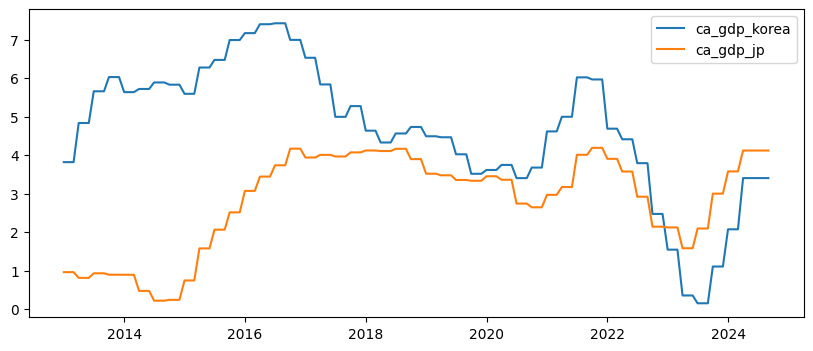

In [51]:
#stationary process
plt.plot(df_merged.loc['2012-12-26':]['ca_gdp_korea'], label = 'ca_gdp_korea')
plt.plot(df_merged.loc['2012-12-26':]['ca_gdp_jp'], label = 'ca_gdp_jp')
plt.legend()
plt.show()

### GDP Growth

In [52]:
df_merged['gdp_growth_korea2'] = df_merged['gdp_korea'].pct_change(periods = 12) * 100
df_merged['gdp_growth_jp2'] = df_merged['gdp_jp'].pct_change(periods = 12) * 100

### Inflation (YoY, Y/Y)

In [54]:
df_merged['infl_korea'] = df_merged['cpi_korea'].pct_change(periods = 12) * 100
df_merged['infl_jp'] = df_merged['cpi_jp'].pct_change(periods = 12) * 100

### 상대적 인플레이션 & 금리 차이

In [55]:
df_merged['infl_diff'] = df_merged['infl_korea'] - df_merged['infl_jp']
df_merged['int_rate_diff'] = df_merged['int_rate_korea'] - df_merged['int_rate_jp']

### GDP 대비 외환보유액 및 증가율

In [56]:
df_merged['reserves_to_gdp'] = df_merged['foreign_reserves'] / df_merged['gdp_korea'] / 1000 * 100
df_merged['reserves_growth'] = df_merged['foreign_reserves'].pct_change(periods = 12) * 100

### 필요한 컬럼만 남김

In [57]:
df_sample = df_merged[[
    'F12.ann_ret', 'real_xr',
    'ca_gdp_korea', 'ca_gdp_jp',
    'gdp_growth_korea', 'gdp_growth_jp',
    'infl_diff', 'int_rate_diff',
    'reserves_to_gdp', 'reserves_growth'
]]

In [58]:
df_sample = df_sample.dropna()
df_sample = df_sample.loc['1998-12-31':]

In [59]:
df_sample.head(3)

,F12.ann_ret,real_xr,ca_gdp_korea,ca_gdp_jp,gdp_growth_korea,gdp_growth_jp,infl_diff,int_rate_diff,reserves_to_gdp,reserves_growth
date,,,,,,,,,,
1998-12-31,6.489981,0.004422,10.477291,2.798314,-3.383,-0.676,3.367014,2.56,13.592840,155.033859
1999-01-31,3.873215,0.004610,10.477291,2.798314,-3.383,-0.676,1.269399,2.11,13.999523,127.925687
1999-02-28,0.651967,0.004533,10.477291,2.798314,-3.383,-0.676,0.265566,1.80,14.485070,107.584787


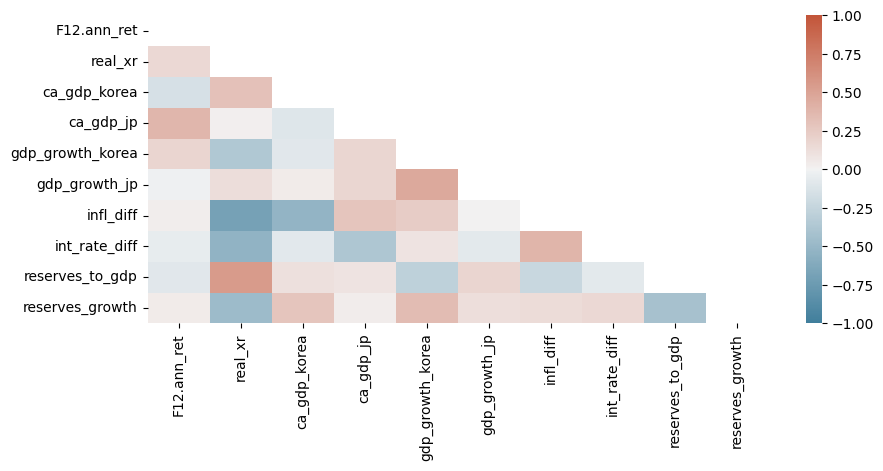

In [60]:
corr = df_sample.corr()
# triu = upper triangle
mask = np.triu(np.ones_like(corr))
cmap=sns.diverging_palette(230, 20, as_cmap = True)
mask=np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, cmap = cmap, vmin = -1, vmax = 1)
plt.show()

In [62]:
X = df_sample
X = sm.add_constant(X)
Y = df_sample['F12.ann_ret']

sm.OLS(Y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            F12.ann_ret   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.107e+31
Date:                Sun, 11 Aug 2024   Prob (F-statistic):               0.00
Time:                        11:33:09   Log-Likelihood:                 9193.4
No. Observations:                 297   AIC:                        -1.836e+04
Df Residuals:                     286   BIC:                        -1.832e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2.309e-14   7.15e-15     -3.232      0.001   -3.72e-14   -9.03e-15
F12.ann_ret          1.0000   5.11e-17   1.96e+16      0.000       1.000       1.000
real_xr           2.046e-12   9.02e-13      2.269      0.024    2.71e-13    3.82e-12
ca_gdp_korea     -8.327e-17   3.25e-16     -0.257      0.798   -7.22e-16    5.56e-16
ca_gdp_jp         1.553e-15   7.72e-16      2.011      0.045    3.29e-17    3.07e-15
gdp_growth_korea  6.106e-16   2.57e-16      2.377      0.018    1.05e-16    1.12e-15
gdp_growth_jp    -3.886e-16   2.86e-16     -1.357      0.176   -9.52e-16    1.75e-16
infl_diff         8.882e-16   5.49e-16      1.617      0.107   -1.93e-16    1.97e-15
int_rate_diff     8.604e-16   6.56e-16      1.312      0.190    -4.3e-16    2.15e-15
reserves_to_gdp   1.527e-16   2.24e-16      0.680      0.497   -2.89e-16    5.94e-16
reserves_growth   2.047e-16   4.12e-17      4.972      0.000    1.24e-16    2.86e-16
==============================================================================
Omnibus:                      183.834   Durbin-Watson:                   0.134
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2009.542
Skew:                           2.349   Prob(JB):                         0.00
Kurtosis:                      14.845   Cond. No.                     5.04e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Fetch Additional Datasources

In [67]:
# Collect Item Codes
stat_codes = fetch_bok_data('StatisticTableList')
stat_codes

https://ecos.bok.or.kr/api/StatisticTableList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000


,P_STAT_CODE,STAT_CODE,STAT_NAME,CYCLE,SRCH_YN,ORG_NAME
0,*,0000000001,1. 통화/금융,None,N,None
1,0000000001,0000000002,1.1. 통화/유동성,None,N,None
2,0000000002,0000000003,1.1.1. 본원통화,None,N,None
3,0000000003,0000000004,1.1.1.1. 본원통화 구성내역,None,N,None
4,0000000004,102Y004,"1.1.1.1.1. 본원통화 구성내역(평잔, 계절조정계열)",M,Y,None
...,...,...,...,...,...,...
972,0000000447,251Y002,9.2.1.2. 한국/북한 배율,A,Y,None
973,0000000396,251Y001,9.2.2. 북한의 경제활동별 국내총생산,A,Y,한국은행
974,0000000396,0000000704,9.2.3. 북한의 시장물가와 환율,None,N,None
975,0000000704,252Y001,9.2.3.1. 시장물가지수,Q,Y,한국은행


In [68]:
TARGET_STAT_CODES = {
    '731Y001': 'krw_xr', # 3.1.1.1. 주요국 통화의 대원화환율 from 서울외국환중개 - Daily
    '902Y006': 'policy_ir', # 9.1.1.3. 국제 주요국 중앙은행 정책금리 from BIS - Monthly
    '902Y004': 'mon_base', # 9.1.1.1. 국제 주요국 본원통화 from IMF - Monthly
    '902Y005': 'mon_broad', # 9.1.1.2. 국제 주요국 광의통화 from IMF - Monthly
    '902Y012': 'export', # 9.1.3.4. 국제 주요국 수출(통관기준) from IMF - Monthly
    '902Y013': 'import', # 9.1.3.5. 국제 주요국 수입(통관기준) from IMF - Monthly
    '902Y014': 'foreign_reserve', # 9.1.3.6. 국제 주요국 외환보유액 from IMF - Monthly
    '902Y002': 'stock', # 9.1.6.2. 국제 주요국 주가지수 from OECD - Monthly
    '902Y020': 'ipi', # 9.1.5.1. 국제 주요국 산업생산지수(계절변동조정) from OECD
    '902Y021': 'unemployment', # 9.1.5.2. 국제 주요국 실업률(계절변동조정) from OECD - Monthly
    '902Y016': 'gdp', # 9.1.4.2. 국제 주요국 국내총생산(GDP) from OECD - Annual
}

In [69]:
dfs = []

for stat_code in TARGET_STAT_CODES.keys() :
    df = fetch_bok_data('StatisticItemList', stat_code=stat_code) # 통계 세부항목 목록
    dfs.append(df)

https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/731Y001
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y006
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y004
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y005
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y012
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y013
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y014
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y002
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y020
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y021
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y016

In [70]:
df_items = pd.concat(dfs, axis=0)
#df_items = df_items.set_index(['STAT_CODE', 'ITEM_CODE', 'CYCLE'])

In [71]:
idx01 = df_items['STAT_CODE'] == '731Y001'
idx02 = df_items['ITEM_CODE'] == '0000002'

idx11 = df_items['ITEM_NAME'].str.find('한국') >= 0
idx12 = df_items['ITEM_NAME'].str.find('일본') >= 0
idx13 = df_items['CYCLE'] == 'M'

idx21 = df_items['STAT_CODE'] == '902Y016'

df_items = df_items.loc[(idx01 * idx02) + ((idx11 + idx12) * idx13) + ((idx11 + idx12) * idx21)]
df_items

,STAT_CODE,STAT_NAME,GRP_CODE,GRP_NAME,ITEM_CODE,ITEM_NAME,P_ITEM_CODE,P_ITEM_NAME,CYCLE,START_TIME,END_TIME,DATA_CNT,UNIT_NAME,WEIGHT
2,731Y001,3.1.1.1. 주요국 통화의 대원화환율,Group1,계정항목,0000002,원/일본엔(100엔),None,None,D,19770401,20240809,13150,원,None
0,902Y006,9.1.1.3. 국제 주요국 중앙은행 정책금리,Group1,계정항목,KR,한국,None,None,M,199905,202406,302,%,None
14,902Y006,9.1.1.3. 국제 주요국 중앙은행 정책금리,Group1,계정항목,JP,일본,None,None,M,194601,202407,827,%,None
1,902Y004,9.1.1.1. 국제 주요국 본원통화,Group1,계정항목,KR,한국,None,None,M,200112,202405,270,백만KRW,None
25,902Y004,9.1.1.1. 국제 주요국 본원통화,Group1,계정항목,JP,일본,None,None,M,200112,202402,267,백만JPY,None
1,902Y005,9.1.1.2. 국제 주요국 광의통화,Group1,계정항목,KR,한국,None,None,M,200112,202404,269,백만KRW,None
23,902Y005,9.1.1.2. 국제 주요국 광의통화,Group1,계정항목,JP,일본,None,None,M,200112,202402,267,백만JPY,None
1,902Y012,9.1.3.4. 국제 주요국 수출(통관기준),Group1,계정항목,KR,한국,None,None,M,200601,202405,221,백만달러,None
67,902Y012,9.1.3.4. 국제 주요국 수출(통관기준),Group1,계정항목,JP,일본,None,None,M,200601,202404,220,백만달러,None
1,902Y013,9.1.3.5. 국제 주요국 수입(통관기준),Group1,계정항목,KR,한국,None,None,M,200601,202405,221,백만달러,None


In [78]:
def fetch_bok_data(service_code, stat_code=None, item=None) :
    url = f"{BOK_API_URL}/{service_code}/{BOK_API_KEY}/json/kr/1/100000"

    if item is not None: 
        url += "/{}/{}/{}/{}/{}".format(item['STAT_CODE'], item['CYCLE'], item['START_TIME'], item['END_TIME'], item['ITEM_CODE'])
#        if type(item['ITEM_CODE2']) is str :
#            url += f"/{item['ITEM_CODE2']}"
                
    elif stat_code : 
        url += f"/{stat_code}"
        
    print(url)
    resp = requests.get(url)
    results = resp.json()
    rows = results[service_code]['row']
    df = pd.DataFrame(rows)

    return df

In [79]:
# iterate over rows
for idx, row in df_items.iterrows():
    name = TARGET_STAT_CODES.get(row['STAT_CODE']) + '_' + row['ITEM_CODE'].lower()
    print(f"Downloading {name}...")

    df = fetch_bok_data('StatisticSearch', item=row) # 통계 조회조건 설정
    df = df[['TIME', 'DATA_VALUE']]

    if row['CYCLE'] == 'D' :
        df['date'] = pd.to_datetime(df['TIME'])
        
    elif row['CYCLE'] == 'M' :
        df['date'] = pd.to_datetime(df['TIME'], format='%Y%m') + MonthEnd()
        
    elif row['CYCLE'] == 'Q' :
        df['year'] = df['TIME'].str[:4]
        df['month'] = df['TIME'].str[-1].astype(int) * 3
        df['day'] = 1
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']]) + MonthEnd()
        
    elif row['CYCLE'] == 'A' :
        df['date'] = pd.to_datetime(df['TIME']) + YearEnd()
        
    else :
        raise RuntimeError()
    
    df = df[['date', 'DATA_VALUE']]
    df = df.rename(columns={'DATA_VALUE': name})
    df[name] = df[name].astype(float)

    df.to_excel(f"data/{name}.xlsx", index=False)
    print()

print("** Completed!! **")

https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/731Y001/D/19770401/20240809/0000002

https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y006/M/199905/202406/KR

https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y006/M/194601/202407/JP

https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y004/M/200112/202405/KR

https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y004/M/200112/202402/JP

https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y005/M/200112/202404/KR

https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y005/M/200112/202402/JP

https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y012/M/200601/202405/KR

https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y012/M/200601/202404/JP

https://ec

In [80]:
filenames = [
    'krw_xr_0000002',
    'policy_ir_kr',
    'policy_ir_jp',
    'mon_base_kr',
    'mon_base_jp',
    'mon_broad_kr',
    'mon_broad_jp',
    'export_kr',
    'export_jp',
    'import_kr',
    'import_jp',
    'foreign_reserve_kr',
    'foreign_reserve_jp',
    'stock_kor',
    'stock_jpn',
    'ipi_kor',
    'ipi_jpn',
    'unemployment_kor',
    'unemployment_jpn',
    'gdp_kor',
    'gdp_jpn',
    'wui_kor',
    'wui_jpn',
]

In [82]:
dfs = []

for fname in filenames :
    print(f"Loading {fname}...")

    df = pd.read_excel(f"data/{fname}.xlsx")
    df = df.set_index('date')

    dfs.append(df)

print("** Completed! **")
dfs

Loading krw_xr_0000002...
Loading policy_ir_kr...
Loading policy_ir_jp...
Loading mon_base_kr...
Loading mon_base_jp...
Loading mon_broad_kr...
Loading mon_broad_jp...
Loading export_kr...
Loading export_jp...
Loading import_kr...
Loading import_jp...
Loading foreign_reserve_kr...
Loading foreign_reserve_jp...
Loading stock_kor...
Loading stock_jpn...
Loading ipi_kor...
Loading ipi_jpn...
Loading unemployment_kor...
Loading unemployment_jpn...
Loading gdp_kor...
Loading gdp_jpn...
Loading wui_kor...
Loading wui_jpn...
** Completed! **


[            krw_xr_0000002
 date                      
 1977-04-01          174.50
 1977-04-02          174.50
 1977-04-04          174.50
 1977-04-06          177.40
 1977-04-07          177.23
 ...                    ...
 2024-08-05          938.67
 2024-08-06          937.18
 2024-08-07          949.49
 2024-08-08          940.13
 2024-08-09          934.32
 
 [13150 rows x 1 columns],
             policy_ir_kr
 date                    
 1999-05-31          4.75
 1999-06-30          4.75
 1999-07-31          4.75
 1999-08-31          4.75
 1999-09-30          4.75
 ...                  ...
 2024-02-29          3.50
 2024-03-31          3.50
 2024-04-30          3.50
 2024-05-31          3.50
 2024-06-30          3.50
 
 [302 rows x 1 columns],
             policy_ir_jp
 date                    
 1946-01-31          3.29
 1946-02-28          3.29
 1946-03-31          3.29
 1946-04-30          3.29
 1946-05-31          3.29
 ...                  ...
 2024-03-31          0.05
 2024-04

In [83]:
df_merged = pd.concat(dfs, axis=1)
df_merged.rename(columns={'krw_xr_0000002': 'krw_jpy_xr'}, inplace=True)
df_merged = df_merged.sort_index()
df_merged

,krw_jpy_xr,policy_ir_kr,policy_ir_jp,mon_base_kr,mon_base_jp,mon_broad_kr,mon_broad_jp,export_kr,export_jp,import_kr,...,stock_kor,stock_jpn,ipi_kor,ipi_jpn,unemployment_kor,unemployment_jpn,gdp_kor,gdp_jpn,wui_kor,wui_jpn
date,,,,,,,,,,,,,,,,,,,,,
1946-01-31,NaN,NaN,3.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-02-28,NaN,NaN,3.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-03-31,NaN,NaN,3.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-04-30,NaN,NaN,3.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-05-31,NaN,NaN,3.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,938.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-06,937.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-07,949.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
df_merged = df_merged['2012-12-31':]
df_merged = df_merged.resample('ME').last()
df_merged = df_merged.ffill()
df_merged

,krw_jpy_xr,policy_ir_kr,policy_ir_jp,mon_base_kr,mon_base_jp,mon_broad_kr,mon_broad_jp,export_kr,export_jp,import_kr,...,stock_kor,stock_jpn,ipi_kor,ipi_jpn,unemployment_kor,unemployment_jpn,gdp_kor,gdp_jpn,wui_kor,wui_jpn
date,,,,,,,,,,,,,,,,,,,,,
2012-12-31,1247.50,2.75,0.05,88341969.4,138474700.0,1.835642e+09,1.145105e+09,45032.0,63397.0,43109.0,...,98.3,52.5,100.7,97.4,3.1,4.3,1278046.6,6272363.0,NaN,NaN
2013-01-31,1188.47,2.75,0.05,83206115.4,130938400.0,1.844601e+09,1.147010e+09,45674.0,53820.0,45279.0,...,98.8,57.7,102.1,95.4,3.1,4.2,1278046.6,6272363.0,0.069979,0.395928
2013-02-28,1176.20,2.75,0.05,94843448.4,131304200.0,1.853813e+09,1.153551e+09,42336.0,56708.0,40431.0,...,98.4,61.9,100.0,97.0,3.2,4.3,1278046.6,6272363.0,0.069979,0.395928
2013-03-31,1180.13,2.75,0.05,98028199.4,146041000.0,1.868046e+09,1.159293e+09,47318.0,66150.0,44006.0,...,99.0,66.4,98.9,97.9,3.0,4.1,1278046.6,6272363.0,0.069979,0.395928
2013-04-30,1132.04,2.75,0.05,94747664.4,155280400.0,1.860901e+09,1.165087e+09,46165.0,59118.0,43656.0,...,96.4,71.7,99.7,98.1,3.0,4.1,1278046.6,6272363.0,0.074895,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,882.68,3.50,0.05,268507477.0,664558600.0,3.971094e+09,1.627906e+09,56175.0,58354.0,54721.0,...,133.0,174.5,118.1,91.7,2.8,2.6,1712792.9,4212945.2,0.000000,0.000000
2024-05-31,877.84,3.50,0.05,277730534.0,664558600.0,3.971094e+09,1.627906e+09,58042.0,58354.0,53187.0,...,134.7,176.6,117.4,92.8,2.8,2.6,1712792.9,4212945.2,0.000000,0.000000
2024-06-30,864.31,3.50,0.05,277730534.0,664558600.0,3.971094e+09,1.627906e+09,58042.0,58354.0,53187.0,...,136.5,177.8,118.0,92.8,2.8,2.5,1712792.9,4212945.2,0.000000,0.000000


In [85]:
# Y. F12.ann_ret
df_merged['ann_ret'] = df_merged['krw_jpy_xr'].pct_change(periods=12) * 100
df_merged['F12.ann_ret'] = df_merged['ann_ret'].shift(-12)
df_merged[['ann_ret', 'F12.ann_ret']]

,ann_ret,F12.ann_ret
date,,
2012-12-31,NaN,-19.466132
2013-01-31,NaN,-12.180366
2013-02-28,NaN,-11.169869
2013-03-31,NaN,-11.981731
2013-04-30,NaN,-11.194834
...,...,...
2024-04-30,-11.787574,NaN
2024-05-31,-7.203112,NaN
2024-06-30,-4.703573,NaN


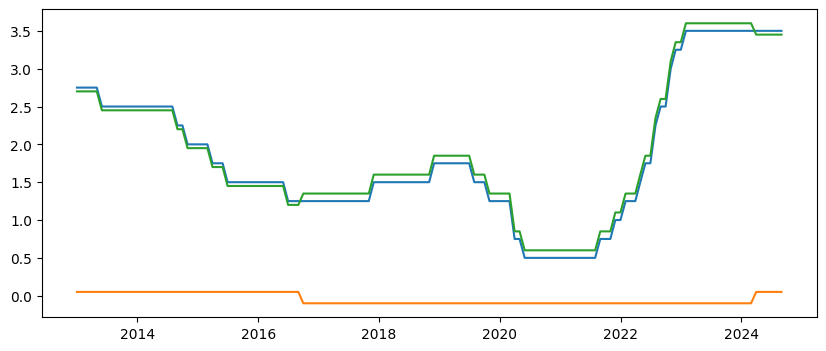

In [86]:
# X1. 한일 정책금리 차이
df_merged['policy_ir_diff'] = df_merged['policy_ir_kr'] - df_merged['policy_ir_jp']
df_merged['policy_ir_diff_rt'] = df_merged['policy_ir_diff'].pct_change(periods=12) * 100

plt.rcParams['figure.figsize'] = (10, 4)

plt.plot(df_merged[['policy_ir_kr', 'policy_ir_jp', 'policy_ir_diff']])
plt.show()

In [88]:
adf_result = adfuller(df_merged['policy_ir_diff'])
adf_result # adf_result[1] < 0.05이면 stationary

(np.float64(-1.5292726433501067),
 np.float64(0.518984102300663),
 3,
 137,
 {'1%': np.float64(-3.479007355368944),
  '5%': np.float64(-2.8828782366015093),
  '10%': np.float64(-2.5781488587564603)},
 np.float64(-196.62168173567488))

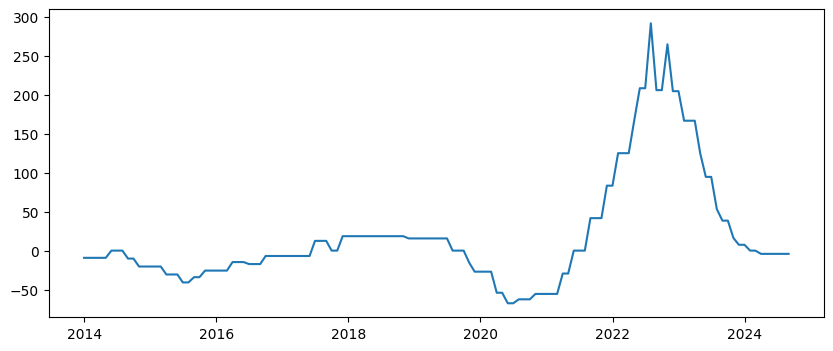

In [89]:
plt.plot(df_merged[['policy_ir_diff_rt']])
plt.show()

In [90]:
adf_result = adfuller(df_merged['policy_ir_diff_rt'].dropna())
adf_result # adf_result[1] < 0.05이면 stationary

(np.float64(-3.8250845816449606),
 np.float64(0.0026608454735502912),
 6,
 122,
 {'1%': np.float64(-3.4851223522012855),
  '5%': np.float64(-2.88553750045158),
  '10%': np.float64(-2.5795685622144586)},
 np.float64(959.5452814491402))

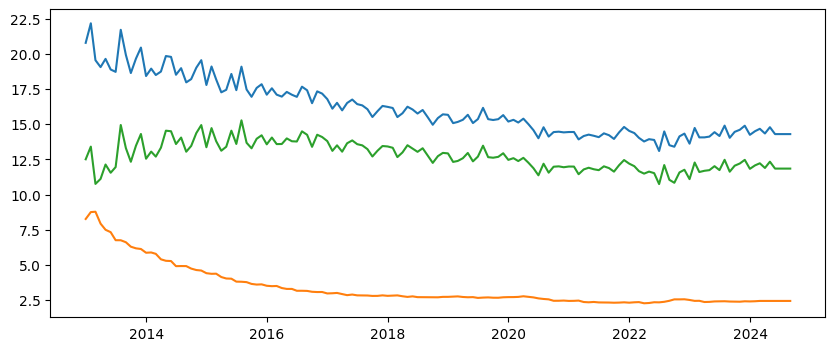

In [91]:
# X2. 한일 통화승수 차이
df_merged['mon_multiplier_kr'] = df_merged['mon_broad_kr'] / df_merged['mon_base_kr']
df_merged['mon_multiplier_jp'] = df_merged['mon_broad_jp'] / df_merged['mon_base_jp']
df_merged['mon_multiplier_diff'] = df_merged['mon_multiplier_kr'] - df_merged['mon_multiplier_jp']
df_merged['mon_multiplier_diff_rt'] = df_merged['mon_multiplier_diff'].pct_change(periods=12) * 100

plt.plot(df_merged[['mon_multiplier_kr', 'mon_multiplier_jp', 'mon_multiplier_diff']])
plt.show()

In [92]:
adf_result = adfuller(df_merged['mon_multiplier_diff'])
adf_result # adf_result[1] < 0.05이면 stationary

(np.float64(-0.782760990245949),
 np.float64(0.8241335243750401),
 14,
 126,
 {'1%': np.float64(-3.4833462346078936),
  '5%': np.float64(-2.8847655969877666),
  '10%': np.float64(-2.5791564575459813)},
 np.float64(132.29653683983))

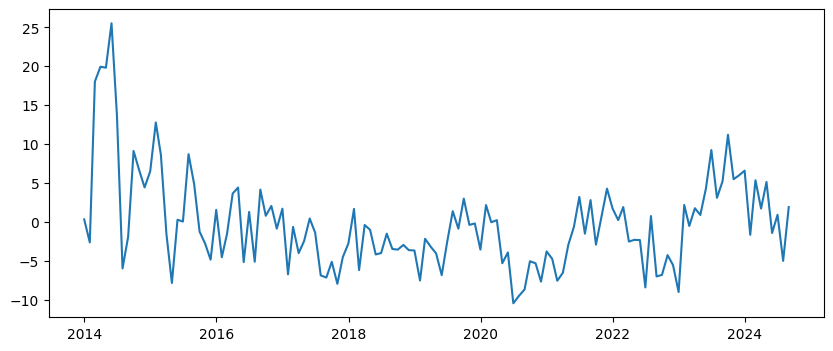

In [93]:
plt.plot(df_merged[['mon_multiplier_diff_rt']])
plt.show()

In [94]:
adf_result = adfuller(df_merged['mon_multiplier_diff_rt'].dropna())
adf_result # adf_result[1] < 0.05이면 stationary

(np.float64(-2.9657753291673554),
 np.float64(0.03821653474335602),
 13,
 115,
 {'1%': np.float64(-3.4885349695076844),
  '5%': np.float64(-2.887019521656941),
  '10%': np.float64(-2.5803597920604915)},
 np.float64(598.4418301659375))

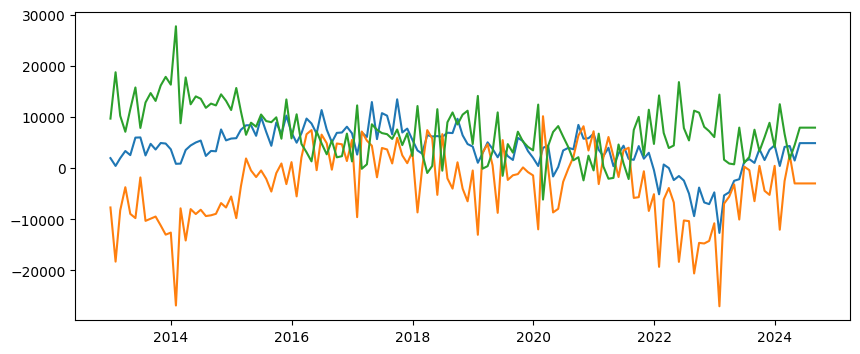

In [96]:
# X3. 한일 무역수지 차이
df_merged['trade_balance_kr'] = df_merged['export_kr'] - df_merged['import_kr']
df_merged['trade_balance_jp'] = df_merged['export_jp'] - df_merged['import_jp']
df_merged['trade_balance_diff'] = df_merged['trade_balance_kr'] - df_merged['trade_balance_jp']
plt.plot(df_merged[['trade_balance_kr', 'trade_balance_jp', 'trade_balance_diff']])
plt.show()

In [97]:
adf_result = adfuller(df_merged['trade_balance_diff'])
adf_result # adf_result[1] < 0.05이면 stationary

(np.float64(-3.09013398311475),
 np.float64(0.02729198583433292),
 14,
 126,
 {'1%': np.float64(-3.4833462346078936),
  '5%': np.float64(-2.8847655969877666),
  '10%': np.float64(-2.5791564575459813)},
 np.float64(2420.79778827939))

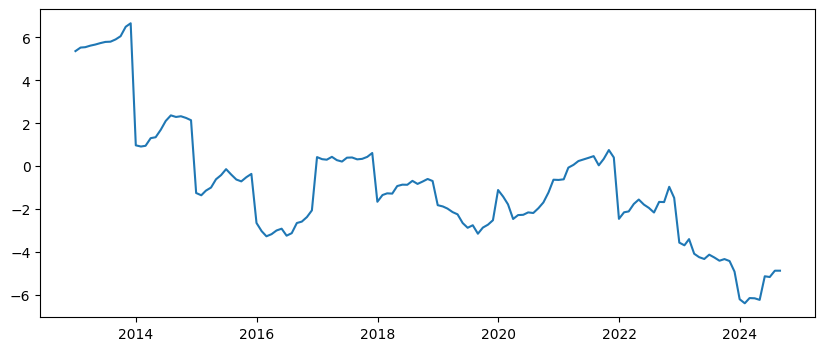

In [99]:
# X4. 한일 GDP 대비 외환보유액 차이
df_merged['foreign_reserve_to_gdp_kr'] = df_merged['foreign_reserve_kr'] / df_merged['gdp_kor'] * 100
df_merged['foreign_reserve_to_gdp_jp'] = df_merged['foreign_reserve_jp'] / df_merged['gdp_jpn'] * 100
df_merged['foreign_reserve_to_gdp_diff'] = df_merged['foreign_reserve_to_gdp_kr'] - df_merged['foreign_reserve_to_gdp_jp']
df_merged['foreign_reserve_to_gdp_diff_rt'] = df_merged['foreign_reserve_to_gdp_diff'].pct_change(periods=12) * 100

plt.plot(df_merged[['foreign_reserve_to_gdp_diff']])
plt.show()

In [100]:
adf_result = adfuller(df_merged['foreign_reserve_to_gdp_diff'])
adf_result # adf_result[1] < 0.05이면 stationary

(np.float64(-2.144081824767658),
 np.float64(0.22716228476660866),
 0,
 140,
 {'1%': np.float64(-3.4779446621720114),
  '5%': np.float64(-2.8824156122448983),
  '10%': np.float64(-2.577901887755102)},
 np.float64(252.11755513830735))

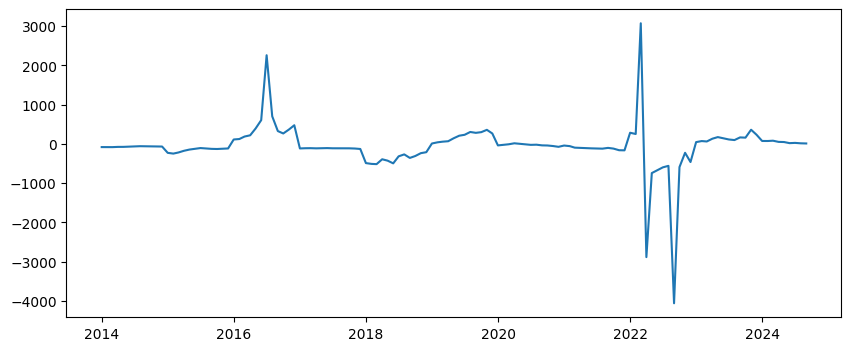

In [101]:
plt.plot(df_merged[['foreign_reserve_to_gdp_diff_rt']])
plt.show()

In [102]:
adf_result = adfuller(df_merged['foreign_reserve_to_gdp_diff_rt'].dropna())
adf_result # adf_result[1] < 0.05이면 stationary

(np.float64(-3.9499934383514743),
 np.float64(0.001696226142972506),
 5,
 123,
 {'1%': np.float64(-3.4846672514209773),
  '5%': np.float64(-2.8853397507076006),
  '10%': np.float64(-2.5794629869786503)},
 np.float64(1795.154408897603))

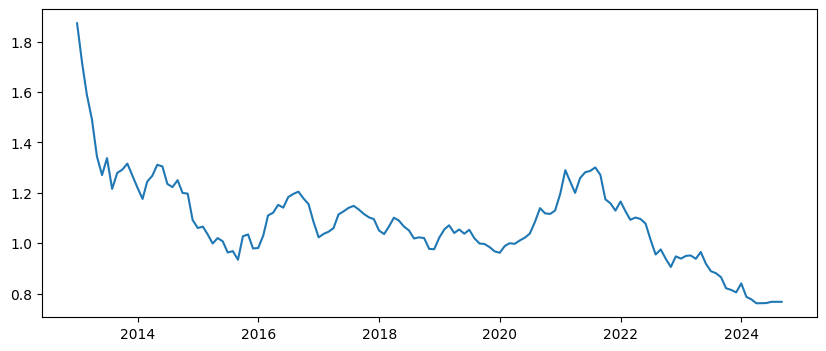

In [103]:
# X5. 한일 주가지수 비율
df_merged['stock_ratio'] = df_merged['stock_kor'] / df_merged['stock_jpn']

plt.plot(df_merged[['stock_ratio']])
plt.show()

In [104]:
adf_result = adfuller(df_merged['stock_ratio'].dropna())
adf_result # adf_result[1] < 0.05이면 stationary

(np.float64(-3.393354911791239),
 np.float64(0.011187498870677349),
 1,
 139,
 {'1%': np.float64(-3.4782936965183815),
  '5%': np.float64(-2.882567574015525),
  '10%': np.float64(-2.5779830117488745)},
 np.float64(-493.4949947326319))

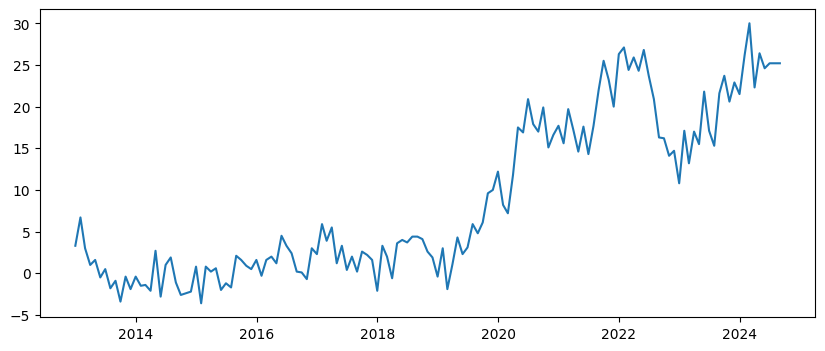

In [105]:
# X6. 한일 산업생산지수(IPI) 차이
df_merged['ipi_diff'] = df_merged['ipi_kor'] - df_merged['ipi_jpn']
df_merged['ipi_diff_rt'] = df_merged['ipi_diff'].pct_change(periods=12) * 100

plt.plot(df_merged[['ipi_diff']])
plt.show()

In [106]:
adf_result = adfuller(df_merged['ipi_diff'])
adf_result # adf_result[1] < 0.05이면 stationary

(np.float64(0.1996459904408805),
 np.float64(0.9722417316265288),
 14,
 126,
 {'1%': np.float64(-3.4833462346078936),
  '5%': np.float64(-2.8847655969877666),
  '10%': np.float64(-2.5791564575459813)},
 np.float64(612.2196130736542))

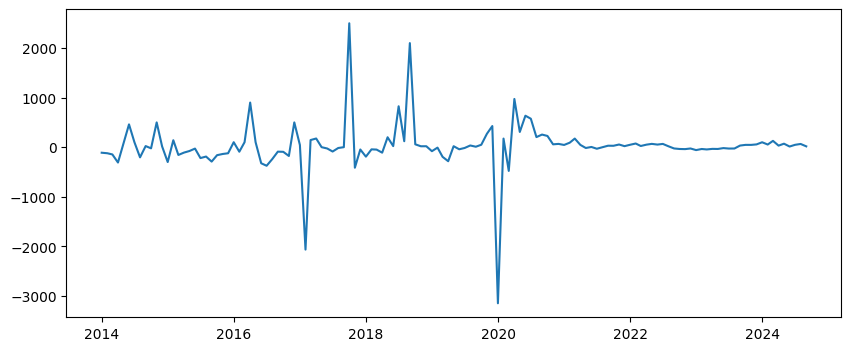

In [107]:
plt.plot(df_merged[['ipi_diff_rt']])
plt.show()

In [108]:
adf_result = adfuller(df_merged['ipi_diff_rt'].dropna())
adf_result # adf_result[1] < 0.05이면 stationary

(np.float64(-11.768787613316599),
 np.float64(1.1026084889979244e-21),
 0,
 128,
 {'1%': np.float64(-3.4825006939887997),
  '5%': np.float64(-2.884397984161377),
  '10%': np.float64(-2.578960197753906)},
 np.float64(1765.2370026662718))

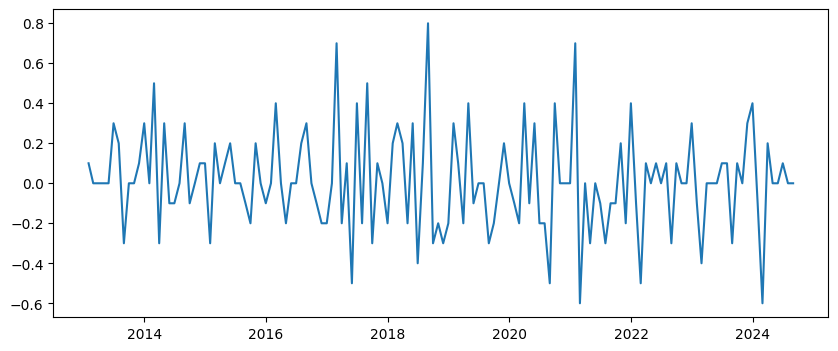

In [110]:
# X7. 한일 실업률 차이
df_merged['unemployment_diff'] = df_merged['unemployment_kor'].diff(1) - df_merged['unemployment_jpn'].diff(1)

plt.plot(df_merged[['unemployment_diff']])
plt.show()

In [111]:
adf_result = adfuller(df_merged['unemployment_diff'].dropna())
adf_result # adf_result[1] < 0.05이면 stationary

(np.float64(-5.687711852704213),
 np.float64(8.206042683700626e-07),
 5,
 134,
 {'1%': np.float64(-3.480118600110386),
  '5%': np.float64(-2.8833618426136196),
  '10%': np.float64(-2.578407034974382)},
 np.float64(-8.310219447381996))

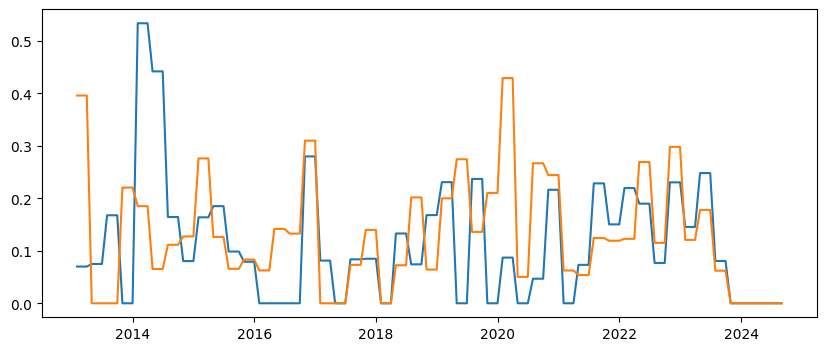

In [112]:
# X8. 한일 World Uncertainty Index(IMF) 차이
plt.plot(df_merged[['wui_kor', 'wui_jpn']])
plt.show()

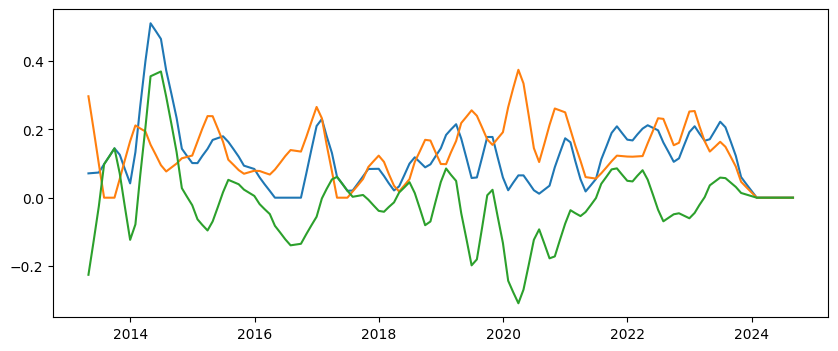

In [114]:
df_merged['wui_kor_ravg'] = df_merged['wui_kor'].rolling(4).mean()
df_merged['wui_jpn_ravg'] = df_merged['wui_jpn'].rolling(4).mean()
df_merged['wui_diff'] = df_merged['wui_kor_ravg'] - df_merged['wui_jpn_ravg']

plt.plot(df_merged[['wui_kor_ravg', 'wui_jpn_ravg', 'wui_diff']])
plt.show()

In [115]:
adf_result = adfuller(df_merged['wui_diff'].dropna())
adf_result # adf_result[1] < 0.05이면 statioanary

(np.float64(-3.8696833082405147),
 np.float64(0.0022696429651888885),
 13,
 123,
 {'1%': np.float64(-3.4846672514209773),
  '5%': np.float64(-2.8853397507076006),
  '10%': np.float64(-2.5794629869786503)},
 np.float64(-622.813977716815))

In [116]:
# Stationary로 변환된 변수들을 모아보자.
df_added = df_merged[[
    'policy_ir_diff_rt',               # X1. 한일 정책금리 차이
    'mon_multiplier_diff_rt',          # X2. 한일 통화승수 차이
    'trade_balance_diff',              # X3. 한일 무역수지 차이
    'foreign_reserve_to_gdp_diff_rt',  # X4. 한일 GDP 대비 외환보유액 차이
    'stock_ratio',                     # X5. 한일 주가지수 비율
    'ipi_diff_rt',                     # X6. 한일 산업생산지수(IPI) 차이
    'unemployment_diff',               # X7. 한일 실업률 차이
    'wui_diff',                        # X8. 한일 World Uncertainty Index(IMF) 차이
    'F12.ann_ret'                      # Y. 수익률(12개월 전)
]]
df_added = df_added.dropna()
df_added.head(15), df_added.tail(15)

(            policy_ir_diff_rt  mon_multiplier_diff_rt  trade_balance_diff  \
 date                                                                        
 2013-12-31          -9.259259                0.321915             16287.0   
 2014-01-31          -9.259259               -2.634988             27702.0   
 2014-02-28          -9.259259               18.028008              8742.0   
 2014-03-31          -9.259259               19.934899             17695.0   
 2014-04-30          -9.259259               19.807872             12447.0   
 2014-05-31           0.000000               25.515939             13991.0   
 2014-06-30           0.000000               13.696122             13533.0   
 2014-07-31           0.000000               -5.973415             11756.0   
 2014-08-31         -10.204082               -1.915004             12586.0   
 2014-09-30         -10.204082                9.113833             12230.0   
 2014-10-31         -20.408163                6.641195          

In [118]:
### Use OLS to fit the forecast model
Y = df_added['F12.ann_ret']
X = df_added.drop('F12.ann_ret', axis=1)
X = sm.add_constant(X)

sm.OLS(Y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            F12.ann_ret   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     7.880
Date:                Sun, 11 Aug 2024   Prob (F-statistic):           2.66e-08
Time:                        12:24:38   Log-Likelihood:                -380.16
No. Observations:                 117   AIC:                             778.3
Df Residuals:                     108   BIC:                             803.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             47.1426      7.462      6.318      0.000      32.351      61.934
policy_ir_diff_rt                 -0.0556      0.009     -6.024      0.000      -0.074      -0.037
mon_multiplier_diff_rt            -0.2086      0.115     -1.812      0.073      -0.437       0.020
trade_balance_diff               8.69e-05      0.000      0.710      0.480      -0.000       0.000
foreign_reserve_to_gdp_diff_rt    -0.0017      0.001     -1.721      0.088      -0.004       0.000
stock_ratio                      -43.7996      6.699     -6.538      0.000     -57.078     -30.521
ipi_diff_rt                    -8.876e-05      0.001     -0.076      0.940      -0.002       0.002
unemployment_diff                  2.0547      2.401      0.856      0.394      -2.705       6.814
wui_diff                          21.8579      6.766      3.231      0.002       8.447      35.268
==============================================================================
Omnibus:                        0.917   Durbin-Watson:                   0.445
Prob(Omnibus):                  0.632   Jarque-Bera (JB):                0.776
Skew:                           0.199   Prob(JB):                        0.678
Kurtosis:                       2.982   Cond. No.                     1.47e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [119]:
# p-value 낮은 변수 drop
X = X.drop(
    [
        'mon_multiplier_diff_rt',
        'trade_balance_diff',
        'foreign_reserve_to_gdp_diff_rt',
        'ipi_diff_rt',
        'unemployment_diff'
    ],
    axis=1
)

sm.OLS(Y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            F12.ann_ret   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     17.43
Date:                Sun, 11 Aug 2024   Prob (F-statistic):           2.28e-09
Time:                        12:25:11   Log-Likelihood:                -384.81
No. Observations:                 117   AIC:                             777.6
Df Residuals:                     113   BIC:                             788.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                48.6441      7.456      6.525      0.000      33.873      63.415
policy_ir_diff_rt    -0.0500      0.009     -5.476      0.000      -0.068      -0.032
stock_ratio         -44.5865      6.771     -6.585      0.000     -58.000     -31.173
wui_diff             17.9882      6.024      2.986      0.003       6.054      29.922
==============================================================================
Omnibus:                        1.202   Durbin-Watson:                   0.326
Prob(Omnibus):                  0.548   Jarque-Bera (JB):                1.269
Skew:                           0.230   Prob(JB):                        0.530
Kurtosis:                       2.779   Cond. No.                     1.32e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""